In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import autograd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

from rebar import g, g_tilde, H, sigma, log_likelihood_bern

sns.set_style("whitegrid")

# Objective

In [14]:
def create_objective(target: float = 0.45):
    def objective(b):
        return (b - target) ** 2
    return objective


target = 0.45
f = create_objective(target=target)
log_pb = log_likelihood_bern

In [15]:
class SigmoidThetaModel(nn.Module):
    """
    A model that learns the parameter theta of a Bernoulli distribution.
    """
    def __init__(self, initial_theta=0.0):
        super(SigmoidThetaModel, self).__init__()
        self.inner_theta = nn.Parameter(torch.tensor([initial_theta], requires_grad=True))
        self.sigmoid = nn.Sigmoid()

    def forward(self):
        return self.sigmoid(self.inner_theta)


class IdentityThetaModel(nn.Module):
    """
    A model that learns the parameter theta of a Bernoulli distribution.
    The parameter is not transformed by sigmoid.
    """
    def __init__(self, initial_theta=0.5):
        super(IdentityThetaModel, self).__init__()
        self.inner_theta = nn.Parameter(torch.tensor([initial_theta], requires_grad=True))

    def forward(self):
        return self.inner_theta

# Rebar insights

In [16]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [56]:
max_iter = 5000

losses = []
variances = []
grad_estimates_list = []
grad_estimates_history = []
z_tilde_history = []
rebar_before_grad_history = []
log_prob_history = []
z_history = []
etas = []
lmbdas = []
thetas = []
rebar_before_grads = []

n_variance_samples = 1024  # N.o samples to compute variance

lmbda = torch.tensor([0.1], requires_grad=True)
eta = torch.tensor([-0.1], requires_grad=True)

theta_model = SigmoidThetaModel(initial_theta=0.0)

opt = torch.optim.Adam(theta_model.parameters(), lr=0.01, betas=(0.9, 0.99999))
opt2 = torch.optim.Adam([eta, lmbda], lr=0.1, betas=(0.9, 0.99999))

for i in tqdm(range(max_iter)):
    theta = theta_model()
    temp_theta = theta.detach().clone().repeat(n_variance_samples, 1)
    temp_theta.requires_grad = True

    # Batch sampling
    u = torch.rand(n_variance_samples, 1) + 1e-9
    v = torch.rand(n_variance_samples, 1) + 1e-9
    z = g(u, temp_theta)
    b = H(z).detach()
    z_tilde = g_tilde(v, b, temp_theta)

    first_term = (f(b) - eta * f(sigma(z_tilde.detach(), lmbda))) * log_pb(b, temp_theta)
    second_term = eta * f(sigma(z, lmbda))
    third_term = -eta * f(sigma(z_tilde, lmbda))
    rebar_before_grad = first_term + second_term + third_term

    log_prob_history.append(log_pb(b, temp_theta).detach())
    rebar_before_grad_history.append(rebar_before_grad.detach())
    rebar_before_grads.append(rebar_before_grad[0].detach().item())

    z_tilde_history.append(z_tilde.detach())
    z_history.append(z.detach())

    grad_estimates = torch.autograd.grad(rebar_before_grad.sum(), temp_theta, create_graph=True)[0]

    grad_estimates_history.append(grad_estimates.detach())

    losses.append(f(torch.bernoulli(temp_theta.detach())).mean().item())
    variances.append(torch.var(grad_estimates.detach()).item())

    # Take one sample Monte Carlo estimate of the gradient
    gradient_estimate = grad_estimates[0]
    grad_estimates_list.append(gradient_estimate.detach().item())

    opt.zero_grad()
    opt2.zero_grad()
    eta.grad, lmbda.grad = torch.autograd.grad(torch.mean(grad_estimates ** 2), (eta,lmbda))
    autograd.backward(theta, gradient_estimate.detach())
    opt.step()
    opt2.step()

    lmbda.data = torch.clamp(lmbda.data, 0.001)

    thetas.append(theta.detach().item())
    etas.append(eta.detach().item())
    lmbdas.append(lmbda.detach().item())

    if torch.isnan(theta).any():
        print("NaN detected")
        break


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:29<00:00, 169.78it/s]


Text(0.5, 1.0, 'Lambda over iterations')

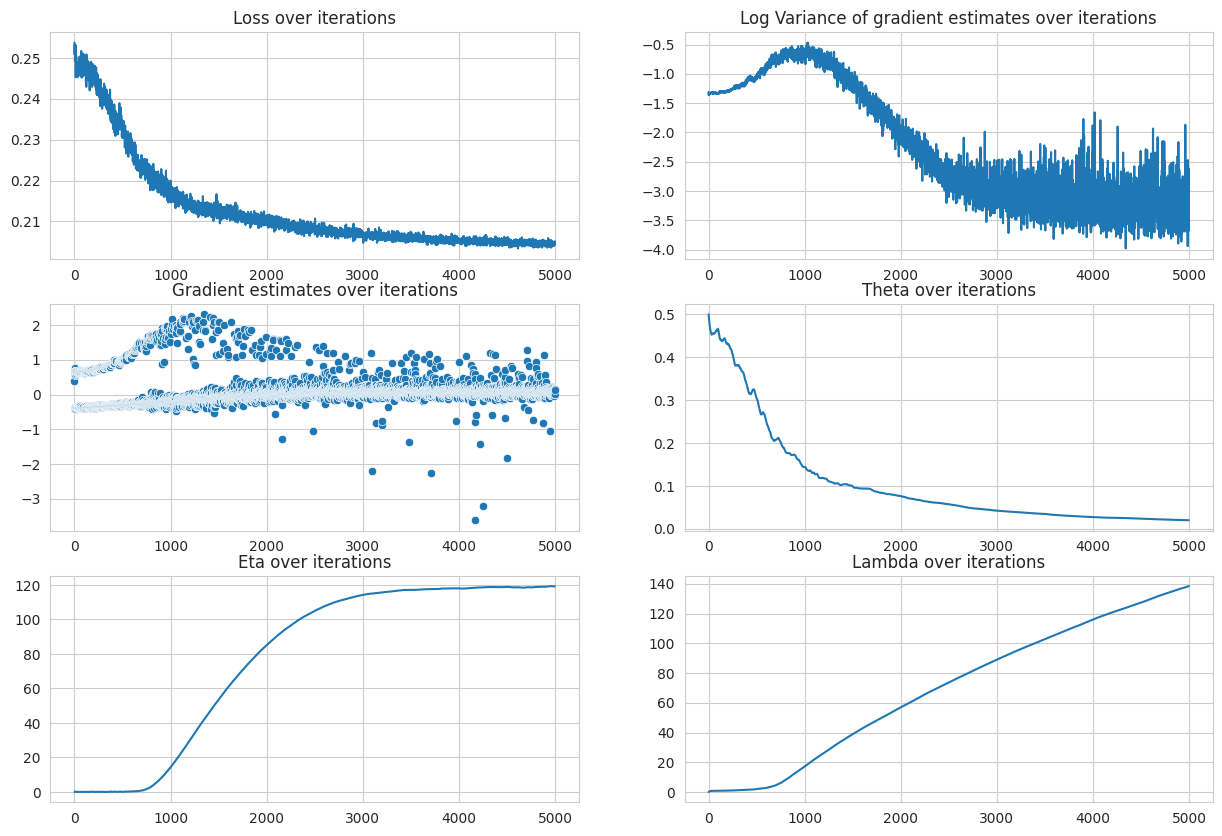

In [57]:
# Create a single figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# Plot the loss
sns.lineplot(x=range(len(losses)), y=losses, ax=axs[0][0])
axs[0][0].set_title('Loss over iterations')
sns.lineplot(x=range(len(losses)), y=np.log(np.array(variances)), ax=axs[0][1])
axs[0][1].set_title('Log Variance of gradient estimates over iterations')
sns.scatterplot(x=range(len(grad_estimates_list)), y=grad_estimates_list, ax=axs[1][0])
axs[1][0].set_title('Gradient estimates over iterations')
sns.lineplot(x=range(len(thetas)), y=thetas, ax=axs[1][1])
axs[1][1].set_title('Theta over iterations')
sns.lineplot(x=range(len(etas)), y=etas, ax=axs[2][0])
axs[2][0].set_title('Eta over iterations')
sns.lineplot(x=range(len(lmbdas)), y=lmbdas, ax=axs[2][1])
axs[2][1].set_title('Lambda over iterations')


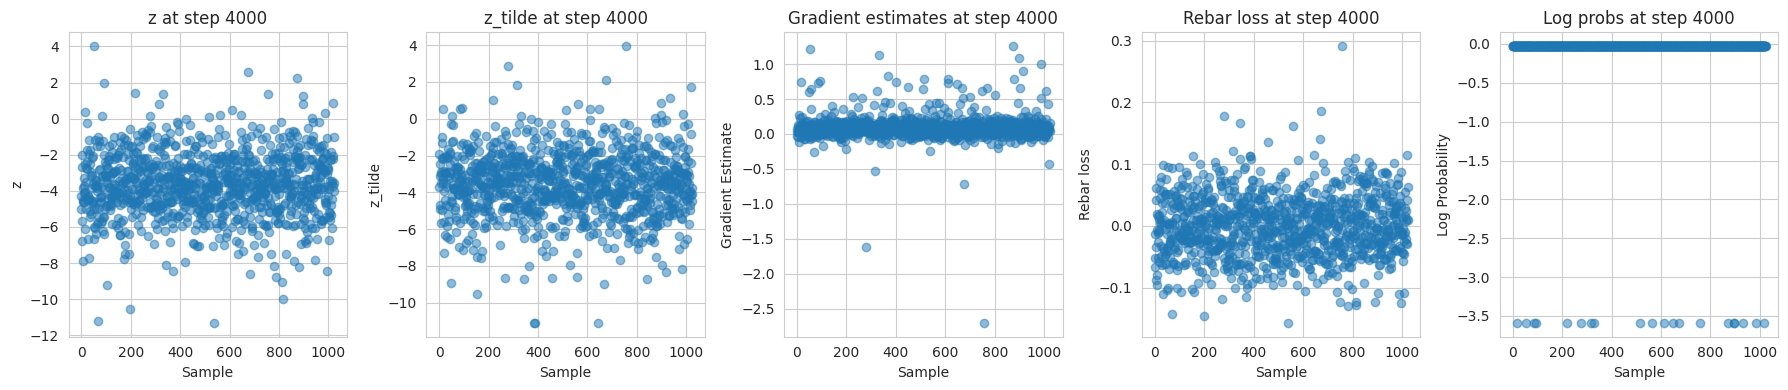

In [58]:
# Select a timestep to visualize, e.g., the last one
timestep = 4000

fig, axes = plt.subplots(1, 5, figsize=(18, 4))

# Scatter plot for z history at the selected timestep
axes[0].scatter(np.arange(n_variance_samples), z_history[timestep].detach().cpu().numpy().flatten(), alpha=0.5)
axes[0].set_title(f'z at step {timestep}')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('z')

# Scatter plot for z_tilde history at the selected timestep
axes[1].scatter(np.arange(n_variance_samples), z_tilde_history[timestep].detach().cpu().numpy().flatten(), alpha=0.5)
axes[1].set_title(f'z_tilde at step {timestep}')
axes[1].set_xlabel('Sample')
axes[1].set_ylabel('z_tilde')

# Scatter plot for grad_estimates history at the selected timestep
axes[2].scatter(np.arange(n_variance_samples), grad_estimates_history[timestep].detach().cpu().numpy().flatten(), alpha=0.5)
axes[2].set_title(f'Gradient estimates at step {timestep}')
axes[2].set_xlabel('Sample')
axes[2].set_ylabel('Gradient Estimate')

axes[3].scatter(np.arange(n_variance_samples), rebar_before_grad_history[timestep].detach().cpu().numpy().flatten(), alpha=0.5)
axes[3].set_title(f'Rebar loss at step {timestep}')
axes[3].set_xlabel('Sample')
axes[3].set_ylabel('Rebar loss')

axes[4].scatter(np.arange(n_variance_samples), log_prob_history[timestep].detach().cpu().numpy().flatten(), alpha=0.5)
axes[4].set_title(f'Log probs at step {timestep}')
axes[4].set_xlabel('Sample')
axes[4].set_ylabel('Log Probability')


plt.tight_layout()
plt.show()

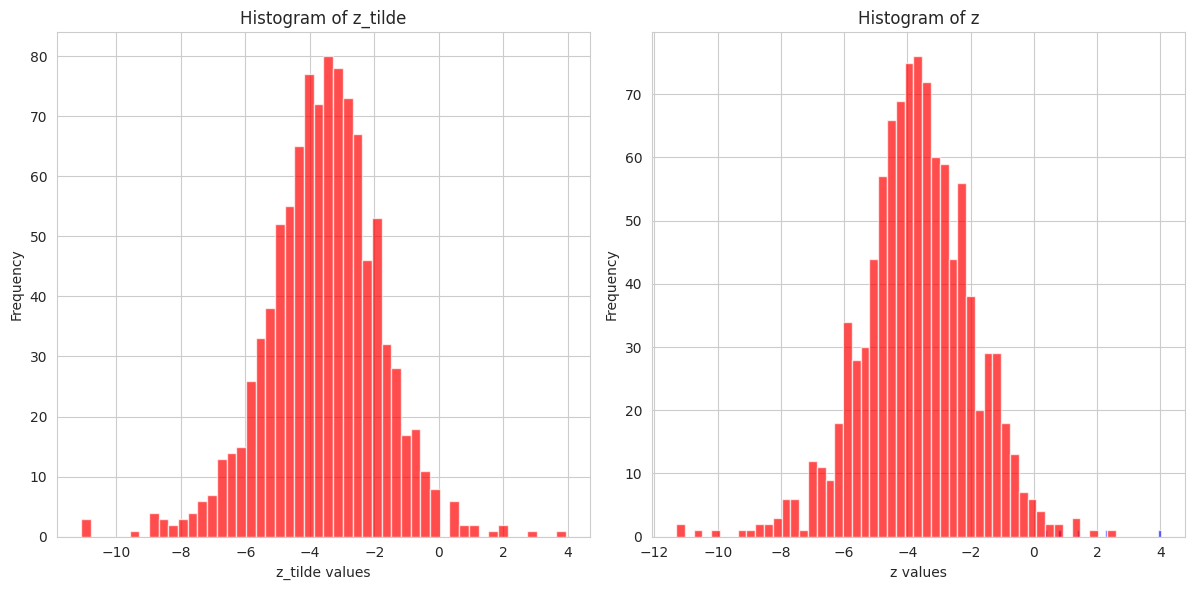

In [59]:
timestep = 4000
stacked_history = torch.stack([z_history[timestep], z_tilde_history[timestep], grad_estimates_history[timestep]]).reshape(3, -1)
stacked_history = stacked_history.permute(1, 0)

plt.figure(figsize=(18, 6))

# Plot for z_tilde (index 1)
plt.subplot(1, 3, 1)
plt.hist(stacked_history[stacked_history[:, 2] > 1][:, 1].detach().cpu().numpy(), bins=50, alpha=0.7, label='z_tilde', color='blue')
plt.hist(stacked_history[stacked_history[:, 2] < 1][:, 1].detach().cpu().numpy(), bins=50, alpha=0.7, label='z_tilde', color='red')
plt.title('Histogram of z_tilde')
plt.xlabel('z_tilde values')
plt.ylabel('Frequency')

# Plot for z (index 0)
plt.subplot(1, 3, 2)
plt.hist(stacked_history[stacked_history[:, 2] > 1][:, 0].detach().cpu().numpy(), bins=50, alpha=0.7, label='z', color='blue')
plt.hist(stacked_history[stacked_history[:, 2] < 1][:, 0].detach().cpu().numpy(), bins=50, alpha=0.7, label='z', color='red')
plt.title('Histogram of z')
plt.xlabel('z values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compare with Reinforce and Concrete

## REINFORCE

In [50]:
reinforce_losses = []
reinforce_variances = []

n_variance_samples = 1024  # N.o samples to compute variance

theta_model = SigmoidThetaModel()
theta_model.train()

opt = torch.optim.Adam([theta_model.inner_theta], lr=0.01, betas=(0.9, 0.99999))

for _ in tqdm(range(max_iter)):

    # Initialize theta
    theta = theta_model.forward()

    temp_theta = theta.detach().clone().repeat(n_variance_samples, 1)
    temp_theta.requires_grad = True

    # Reinforce estimator
    b = torch.bernoulli(temp_theta)
    grad_estimates = f(b) * torch.autograd.grad(log_pb(b, temp_theta).sum(), temp_theta)[0].detach()

    reinforce_losses.append(f(torch.bernoulli(temp_theta.detach())).mean().item())
    reinforce_variances.append(torch.var(grad_estimates.detach()).item())

    # Take one sample Monte Carlo estimate of the gradient
    gradient_estimate = grad_estimates[0]

    opt.zero_grad()
    autograd.backward(theta, gradient_estimate.detach())
    opt.step()

    if torch.isnan(theta).any():
        print("NaN detected")
        break


100%|██████████| 5000/5000 [00:07<00:00, 660.58it/s]


Text(0.5, 1.0, 'Log Variance of gradient estimates over iterations')

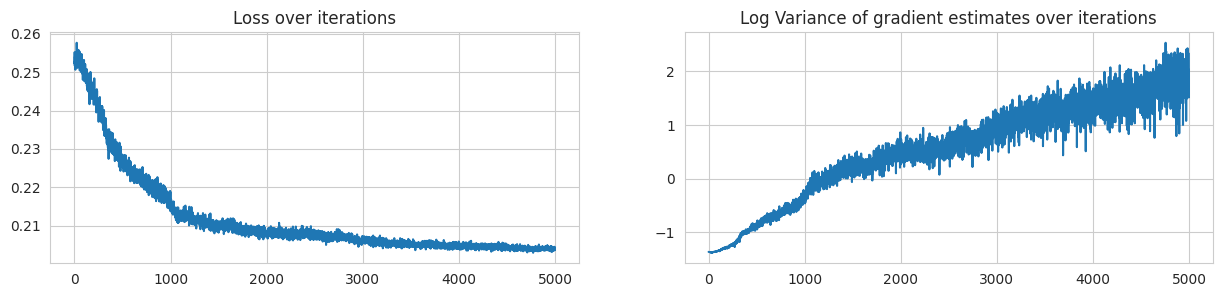

In [51]:
# Create a single figure with subplots
fig, axs = plt.subplots(1,2, figsize=(15, 3))
# Plot the loss
sns.lineplot(x=range(len(reinforce_losses)), y=reinforce_losses, ax=axs[0])
axs[0].set_title('Loss over iterations')
sns.lineplot(x=range(len(reinforce_variances)), y=np.log(np.array(reinforce_variances)), ax=axs[1])
axs[1].set_title('Log Variance of gradient estimates over iterations')

## Concrete 0.5

In [52]:
concrete_losses = []
concrete_variances = []

n_variance_samples = 1024  # N.o samples to compute variance

theta_model = SigmoidThetaModel()
theta_model.train()

lmbda = 0.5
opt = torch.optim.Adam([theta_model.inner_theta], lr=0.01, betas=(0.9, 0.99999))
for _ in tqdm(range(max_iter)):
    # Initialize theta
    theta = theta_model.forward()
    temp_theta = theta.detach().clone().repeat(n_variance_samples, 1)
    temp_theta.requires_grad = True

    u = torch.rand(n_variance_samples, 1) + 1e-9
    z = g(u, temp_theta)

    # concrete estimator
    grad_estimates = torch.autograd.grad(f(sigma(z, lmbda)).sum(), temp_theta)[0].detach()

    concrete_losses.append(f(torch.bernoulli(temp_theta.detach())).mean().item())
    concrete_variances.append(torch.var(grad_estimates.detach()).item())

    # Take one sample Monte Carlo estimate of the gradient
    gradient_estimate = grad_estimates[0]

    opt.zero_grad()
    autograd.backward(theta, gradient_estimate.detach())
    opt.step()

    if torch.isnan(theta).any():
        print("NaN detected")
        break


100%|██████████| 5000/5000 [00:07<00:00, 625.68it/s]


Text(0.5, 1.0, 'Log Variance of gradient estimates over iterations')

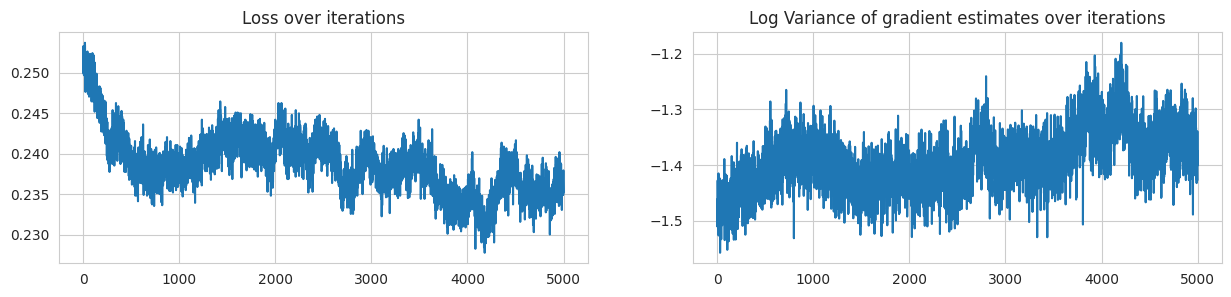

In [54]:
# Create a single figure with subplots
fig, axs = plt.subplots(1,2, figsize=(15, 3))
# Plot the loss
sns.lineplot(x=range(len(concrete_losses)), y=concrete_losses, ax=axs[0])
axs[0].set_title('Loss over iterations')
sns.lineplot(x=range(len(concrete_variances)), y=np.log(np.array(concrete_variances)), ax=axs[1])
axs[1].set_title('Log Variance of gradient estimates over iterations')

# Compare

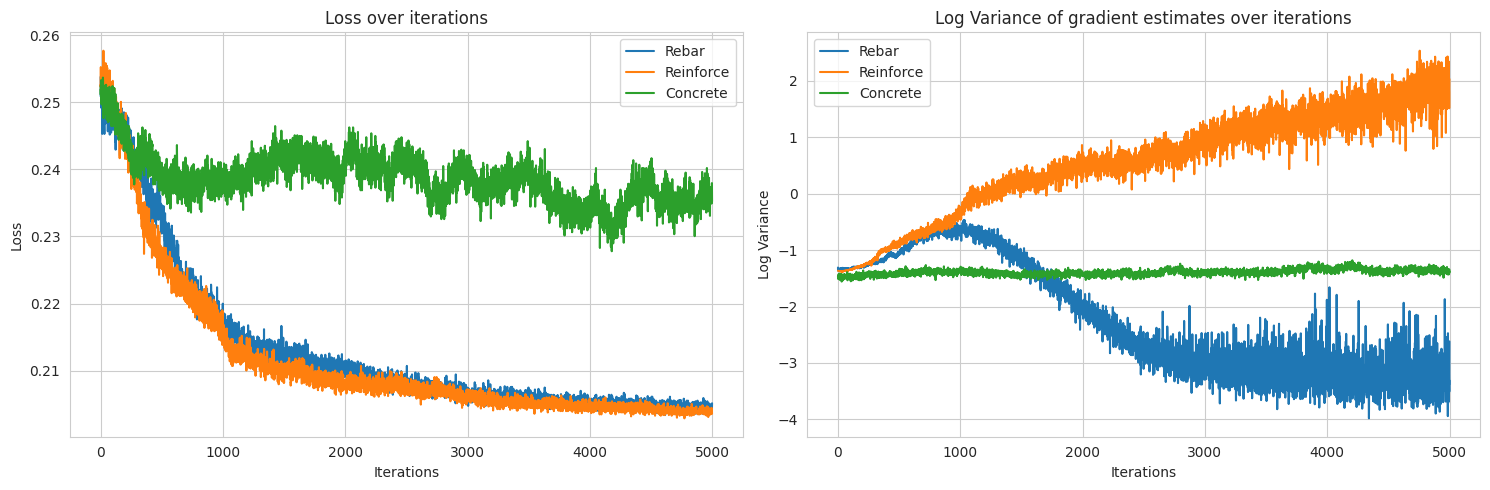

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x=range(len(losses)), y=losses, ax=axs[0], label='Rebar')
sns.lineplot(x=range(len(reinforce_losses)), y=reinforce_losses, ax=axs[0], label='Reinforce')
sns.lineplot(x=range(len(concrete_losses)), y=concrete_losses, ax=axs[0], label='Concrete')
axs[0].set_title('Loss over iterations')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
sns.lineplot(x=range(len(variances)), y=np.log(np.array(variances)), ax=axs[1], label='Rebar')
sns.lineplot(x=range(len(reinforce_variances)), y=np.log(np.array(reinforce_variances)), ax=axs[1], label='Reinforce')
sns.lineplot(x=range(len(concrete_variances)), y=np.log(np.array(concrete_variances)), ax=axs[1], label='Concrete')
axs[1].set_title('Log Variance of gradient estimates over iterations')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Log Variance')
plt.legend()
plt.tight_layout()
plt.show()  